## HW03 Code


You will complete the following notebook, as described in the PDF for Homework 03 (included in the download with the starter code).  You will submit:
1. This notebook file, along with your COLLABORATORS.txt file, to the Gradescope link for code.
2. A PDF of this notebook and all of its output, once it is completed, to the Gradescope link for the PDF.


Please report any questions to the [class Piazza page](piazza.com/tufts/summer2021/cs135).

### Import required libraries.

In [412]:
import os
import numpy as np
import pandas as pd

import warnings

import sklearn.linear_model
import sklearn.metrics
import sklearn.calibration

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

### Function for later use
This function will compute and return a confusion matrix on data, given probabilistic predictions, and a threshold to use when converting probabilities to "firm" predictions.

***Don't change this function.***

In [413]:
def calc_confusion_matrix_for_threshold(ytrue_N, yproba1_N, thresh=0.5):
    ''' Compute the confusion matrix for a given probabilistic classifier and threshold
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset
        Needs to be same size as ytrue_N
    thresh : float
        Scalar threshold for converting probabilities into hard decisions
        Calls an example "positive" if yproba1 >= thresh
        Default value reflects a majority-classification approach (class is the one that gets
        highest probability)

    Returns
    -------
    cm_df : Pandas DataFrame
        Can be printed like print(cm_df) to easily display results
    '''
    cm = sklearn.metrics.confusion_matrix(ytrue_N, yproba1_N >= thresh)
    cm_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
    cm_df.columns.name = 'Predicted'
    cm_df.index.name = 'True'
    return cm_df

## Cancer-Risk Screening

### 1: Compute true/false positives/negatives.

Complete the following code.

In [414]:
def calc_TP_TN_FP_FN(ytrue_N, yhat_N):
    '''
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yhat_N : 1D array of floats
        Each entry represents a predicted binary value (either 0 or 1).
        One entry per example in current dataset.
        Needs to be same size as ytrue_N.

    Returns
    -------
    TP : int
        Number of true positives
    TN : int
        Number of true negatives
    FP : int
        Number of false positives
    FN : int
        Number of false negatives
    '''
    TP = 0.0
    TN = 0.0
    FP = 0.0
    FN = 0.0
    
    for i in range(ytrue_N.size):
        actual = ytrue_N[i]
        predicted = yhat_N[i]
        
        if actual == predicted:
            if actual == 0:
                TN += 1
            else:
                TP += 1
        else:
            if actual == 0:
                FP += 1
            else:
                FN += 1
                
    return TP, TN, FP, FN

#### Testing code
The following four calls to the function above test your results.  ***Don't modify this.***

In [415]:
all0 = np.zeros(10)
all1 = np.ones(10)
calc_TP_TN_FP_FN(all0, all1)

(0.0, 0.0, 10.0, 0.0)

In [416]:
calc_TP_TN_FP_FN(all1, all0)

(0.0, 0.0, 0.0, 10.0)

In [417]:
calc_TP_TN_FP_FN(all1, all1)

(10.0, 0.0, 0.0, 0.0)

In [418]:
calc_TP_TN_FP_FN(all0, all0)

(0.0, 10.0, 0.0, 0.0)

### Load the dataset.

The following should ***not*** be modified.  After it runs, the various arrays it creates will contain the 2- or 3-feature input datasets.

In [419]:
# Load the x-data and y-class arrays
x_train = np.loadtxt('./data_cancer/x_train.csv', delimiter=',', skiprows=1)
x_test = np.loadtxt('./data_cancer/x_test.csv', delimiter=',', skiprows=1)

y_train = np.loadtxt('./data_cancer/y_train.csv', delimiter=',', skiprows=1)
y_test = np.loadtxt('./data_cancer/y_test.csv', delimiter=',', skiprows=1)

### 2: Compute the fraction of patients with cancer.

Complete the following code.  Your solution needs to ***compute*** these values from the training and testing sets (i.e., don't simply hand-count and print the values).

In [420]:
print("Fraction of data that has_cancer on TRAIN: %.3f" % (np.count_nonzero(y_train)/y_train.size))
print("fraction of data that has_cancer on TEST : %.3f" % (np.count_nonzero(y_test)/y_test.size))

Fraction of data that has_cancer on TRAIN: 0.140
fraction of data that has_cancer on TEST : 0.139


### 3: The predict-0-always baseline

#### (a) Compute the accuracy of the always-0 classifier.

Complete the code to compute and print the accuracy of the always-0 classifier on validation and test outputs.

In [421]:
print("acc on TRAIN: %.3f" % sklearn.metrics.accuracy_score(y_train, np.zeros(y_train.size)))
print("acc on TEST: %.3f" % sklearn.metrics.accuracy_score(y_test, np.zeros(y_test.size)))

acc on TRAIN: 0.860
acc on TEST: 0.861


#### (b) Print a confusion matrix for the always-0 classifier.

Add code below to generate a confusion matrix for the always-0 classifier on the test set.

In [422]:
print(calc_confusion_matrix_for_threshold(y_test, np.zeros(y_test.size)))

Predicted    0  1
True             
0          155  0
1           25  0


#### (c) Reflect on the accuracy of the always-0 classifier.

**Answer**: Overall, the accuracy for both the training (0.860) and testing data (0.861) are very close and quite high (relatively close to 1). Accuracy is a measure of how often the classifier is correctand in this scenario, the always-0 classifier's performance is quite good and this is mostly due to luck; Our actual training and testing data consists of a higher proportion of 0s than 1s which explains the accuracy calculated of the always-0 classifier's.

However if we split up the data, the negative data accuracy is 155/155 = 1 (TNR) while the positive data accuracy is 0/25 = 0 (TPR); The always-0 classifier is fully in favor of true negative over true positive data. So, if our data has a way higher proportion of true negatives, the always-0 classifier is something we can possibly use. Otherwise, it is not a wise choice.

#### (d) Analyze the various costs of using the always-0 classifier.

**Answer**: The number of True Positives will always be 0 and the number of False Negatives will always be maximum, always-0 classifier will classify people that have cancer as negative. 

Given the task of this classification experiment, the always-0 classifier is not a wise choice due to the severe cost it will bring; People with cancer will not be able to do biopsies and be not be diagnosed earlier and this will lead to a lost of time that could have been used to do treatment and have a higher chance of being cured. So, these people will end up spending much more money later on once their cancer grows and becomes harder to treat.

### 4: Basic Perceptron Models

#### (a) Create a basic `Perceptron` classifier

Fit a perceptron to the training data.  Print out accuracy on this data, as well as on testing data.  Print out a confusion matrix on the testing data.

In [423]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(x_train)
scaled_xTrain = scaler.transform(x_train)
scaled_xTest = scaler.transform(x_test)
p = sklearn.linear_model.Perceptron()
p.fit(scaled_xTrain, y_train)
pred_yTest = p.predict(scaled_xTest)

print("acc on TRAIN: %.3f" % p.score(scaled_xTrain, y_train))
print("acc on TEST : %.3f" % p.score(scaled_xTest, y_test))
print("\n")
print(calc_confusion_matrix_for_threshold(y_test, pred_yTest))

acc on TRAIN: 0.402
acc on TEST : 0.494


Predicted   0   1
True             
0          64  91
1           0  25


#### (b) Compare the `Perceptron` to the always-0 classifier.

**Answer**: Compared to the always-0 classifier, the perceptron model has a much lower (about half times lower) accuracy on both the training and test data. However, based on the confusion matrix, this model was able to classify all the true 1s as 1s such that the true positive rate is 1.0, which is much more effective than the always-0 classifer with a 0 TPR. This model also has a lower true negative rate as it was not able to classify the true 0s as 0s and actually classified more false positives. 

Overall, even though this model had a lower overall accuracy than the always-0 classifier and performed worse in classifying true negatives, it was able to performed better in classifying true positives. A cost of having a lower true negative rate would mean people that do not have cancer will waste money and time on unnecessary medical purchases, undergoing painful biopsies that could have been avoided; Whereas the benefits of a higher true positive rate would mean people that do have cancer can get biopsies and earlier treatments. 

#### (c) Generate a series of regularized perceptron models
Each model will use a different `alpha` value, multiplying that by the L2 penalty.  You will record and plot the accuracy of each model on both training and test data.

In [424]:
train_accuracy_list = list()
test_accuracy_list = list()
alphas = np.logspace(-5, 5, base=10, num=100)

for a in alphas:
    model = sklearn.linear_model.Perceptron(penalty='l2', alpha = a)
    model.fit(scaled_xTrain, y_train)
    train_accuracy_list.append(model.score(scaled_xTrain, y_train))
    test_accuracy_list.append(model.score(scaled_xTest, y_test))

##### Plot accuracy on train/test data across the different alpha values.

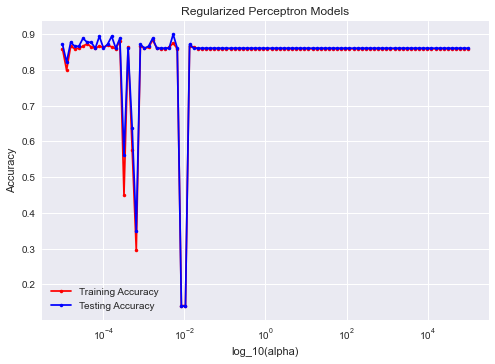

In [425]:
# TODO make plot
plt.xlabel('log_10(alpha)');
plt.ylabel('Accuracy');

plt.xscale('log')
plt.plot(alphas, train_accuracy_list, '.r-', label = 'Training Accuracy')
plt.plot(alphas, test_accuracy_list, '.b-', label = 'Testing Accuracy')
plt.title('Regularized Perceptron Models')
plt.legend()
plt.show()
# TODO add legend, titles, etc.
# plt.legend(...);

#### (d) Discuss what the plot is showing you.

**Answer**: The performance plot shows that when alpha is less than zero, the accuracy trends of the training and testing line fluctuates irregularly, going from small fluctuations to sudden sharp and steep drops from 0.85 to 0.3 in one of the models. Back in the prior assignment of hw2, the ridge regression model performed best in avoiding overfitting when regularization strength is greater than 1 but not too high. However in this model when alpha is close to and greater than 1, the performance showed a consistent accuracy on both testing and training data of about 8.6. This may be becuase since the basic perceptron model's performance is poor, it indicates the need of a higher alpha value to create weight adjustments for the model. Overall, the performance plot shows better and more consistent performance on higher alpha values. 

### 5: Decision functions and probabilistic predictions

#### (a) Create two new sets of predictions

Fit `Perceptron` and `CalibratedClassifierCV` models to the data.  Use their predictions to generate ROC curves. 

In [426]:
# TODO: fit a Perceptron and generate its decision_function() over the test data.
p = sklearn.linear_model.Perceptron()
p.fit(scaled_xTrain, y_train)
conf_P = p.decision_function(scaled_xTest)

# TODO: Build a CalibratedClassifierCV, using a Perceptron as its base_estimator, 
#       and generate its probabilistic predictions over the test data.
cali = sklearn.calibration.CalibratedClassifierCV(base_estimator = p, method = 'isotonic')
cali.fit(scaled_xTrain, y_train)
conf_C = cali.predict_proba(scaled_xTest)

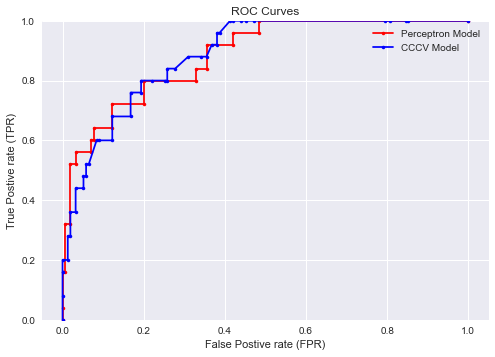

In [427]:
fprP, tprP, thrP = sklearn.metrics.roc_curve(y_test, conf_P)
fprC, tprC, thrC = sklearn.metrics.roc_curve(y_test, conf_C[:,1])

plt.ylim([0, 1]);
plt.xlabel("False Postive rate (FPR)");
plt.ylabel("True Postive rate (TPR)");
plt.plot(fprP, tprP, '.r-', label = 'Perceptron Model')
plt.plot(fprC, tprC, '.b-', label = 'CCCV Model')
plt.title('ROC Curves')
plt.legend()
plt.show()

In [428]:
print("AUC on TEST for Perceptron: %.3f" % sklearn.metrics.roc_auc_score(y_test, conf_P))
print("AUC on TEST for probabilistic model: %.3f" % sklearn.metrics.roc_auc_score(y_test, conf_C[:,1]))

AUC on TEST for Perceptron: 0.884
AUC on TEST for probabilistic model: 0.886


#### (b) Discuss the results above

**Answer**: At first glance, both the model curves seemed to be similar in shape and are above the 'coin-flip' classifier (50% sensitivity and specificity); However, the AUC on TEST for Probabilistic Model (0.886) is greater than that of Perceptron (0.884). This means the Probabilistic Model curve gets a higher true positive rate earlier (fewer false positives) than the Perceptron curve. A Perfect model would have an AUC of 1.0 as it is able to differentiate between the a patient with cancer vs without with 100 % sensitivity and 100 % specificity; So, the Probabilistic Model would be preferred due to its higher AUC value. 


 

#### (c) Compute model metrics for different probabilistic thresholds

Complete the function that takes in a set of correct outputs, a matching set of probabilities generated by a classifier, and a threshold at which to set the positive decision probability, and returns a set of metrics if we use that threshold.

In [429]:
def calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh=0.5):
    ''' Compute performance metrics for a given probabilistic classifier and threshold
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset
        Needs to be same size as ytrue_N
    thresh : float
        Scalar threshold for converting probabilities into hard decisions
        Calls an example "positive" if yproba1 >= thresh
        Default value reflects a majority-classification approach (class is the one that gets
        highest probability)

    Returns
    -------
    acc : accuracy of predictions
    tpr : true positive rate of predictions
    tnr : true negative rate of predictions
    ppv : positive predictive value of predictions
    npv : negative predictive value of predictions
    '''
    acc = 0
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    pred = []

    for i in yproba1_N:
        if i >= thresh:
            pred.append(1)
        else:
            pred.append(0)
    
    TP, TN, FP, FN = calc_TP_TN_FP_FN(ytrue_N, pred)
    
    acc = (TP+TN)/(TP+TN+FP+FN)
    tpr = TP/(TP+FN)
    tnr = TN/(TN+FP)
    if (TP == 0 and FP == 0):
        ppv = 0
    else:
        ppv = TP/(TP+FP)
        
    if (TN == 0 and FN == 0):
        npv = 0
    else:
        npv = TN/(TN+FN)
    
    return acc, tpr, tnr, ppv, npv

# You can use this function later to make printing results easier; don't change it.
def print_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh=0.5):
    ''' Pretty print perf. metrics for a given probabilistic classifier and threshold
    '''
    acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh)
    
    ## Pretty print the results
    print("%.3f ACC" % acc)
    print("%.3f TPR" % tpr)
    print("%.3f TNR" % tnr)
    print("%.3f PPV" % ppv)
    print("%.3f NPV" % npv)

#### (d) Compare the probabilistic classifier across multiple decision thresholds

Try a range of thresholds for classifying data into the positive class (1).  For each threshold, compute the true postive rate (TPR) and positive predictive value (PPV).  Record the best value of each metric, along with the threshold that achieves it, and the *other* metric at that threshold.

In [430]:
# TODO: test different thresholds to compute these values
thresholds = np.linspace(0, 1.001, 51)

currTPR = 0
currPPV = 0
currT = 0

for t in thresholds:
    acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(y_test, conf_C[:,1], t)
    if tpr >= currTPR:
        if tpr == currTPR:
            if ppv > currPPV:
                currTPR = tpr
                currPPV = ppv
                currT = t
        elif tpr > currTPR:
            currTPR = tpr
            currPPV = ppv
            currT = t
            
best_TPR = currTPR
best_PPV_for_best_TPR = currPPV
best_TPR_threshold = currT

currTPR = 0
currPPV = 0
currT = 0
for t in thresholds:
    acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(y_test, conf_C[:,1], t)
    if ppv >= currPPV:
        if ppv == currPPV:
            if tpr > currTPR:
                currPPV = ppv
                currTPR = tpr
                currT = t
        elif ppv > currPPV:
            currPPV = ppv
            currTPR = tpr
            currT = t

best_PPV = currPPV
best_TPR_for_best_PPV = currTPR
best_PPV_threshold = currT

In [431]:
print("TPR threshold: %.4f => TPR: %.4f; PPV: %.4f" % (best_TPR_threshold, best_TPR, best_PPV_for_best_TPR))
print("PPV threshold: %.4f => PPV: %.4f; TPR: %.4f" % (best_PPV_threshold, best_PPV, best_TPR_for_best_PPV))

TPR threshold: 0.0601 => TPR: 1.0000; PPV: 0.2778
PPV threshold: 0.6206 => PPV: 1.0000; TPR: 0.2000


#### (e) Exploring diffrerent thresholds

#### (i) Using default 0.5 threshold. 

Generate confusion matrix and metrics for probabilistic classifier, using threshold 0.5.

In [432]:
best_thr = 0.5
print("ON THE TEST SET:")
print("Chosen best threshold = %.4f" % best_thr)
print("")
print(calc_confusion_matrix_for_threshold(y_test, conf_C[:,1], best_thr))
print("")
print_perf_metrics_for_threshold(y_test, conf_C[:,1], best_thr)

ON THE TEST SET:
Chosen best threshold = 0.5000

Predicted    0   1
True              
0          150   5
1           15  10

0.889 ACC
0.400 TPR
0.968 TNR
0.667 PPV
0.909 NPV


#### (ii) Using threshold with highest TPR. 

Generate confusion matrix and metrics for probabilistic classifier, using threshold that maximizes TPR.

In [433]:
best_thr = best_TPR_threshold
print("ON THE TEST SET:")
print("Chosen best threshold = %.4f" % best_thr)
print("")
print(calc_confusion_matrix_for_threshold(y_test, conf_C[:,1], best_thr))
print("")
print_perf_metrics_for_threshold(y_test, conf_C[:,1], best_thr)

ON THE TEST SET:
Chosen best threshold = 0.0601

Predicted   0   1
True             
0          90  65
1           0  25

0.639 ACC
1.000 TPR
0.581 TNR
0.278 PPV
1.000 NPV


#### (iii) Using threshold with highest PPV. 

Generate confusion matrix and metrics for probabilistic classifier, using threshold that maximizes PPV.

In [434]:
best_thr = best_PPV_threshold
print("ON THE TEST SET:")
print("Chosen best threshold = %.4f" % best_thr)
print("")
print(calc_confusion_matrix_for_threshold(y_test, conf_C[:,1], best_thr))
print("")
print_perf_metrics_for_threshold(y_test, conf_C[:,1], best_thr)

ON THE TEST SET:
Chosen best threshold = 0.6206

Predicted    0  1
True             
0          155  0
1           20  5

0.889 ACC
0.200 TPR
1.000 TNR
1.000 PPV
0.886 NPV


#### (iv) Compare the confusion matrices from (a)–(c) to analyze the different thresholds.

**Answer**: 
Using the default threshold: (Same accuracy as the threshold for best PPV)
The TPR is pretty low which means over 50% of patients that do have cancer will be classified to not undergo biopsies which means people with cancer will not know that they have one until a long time after. For patients without cancer, the TNR shows 96.8% will avoid biopsies but remaining 3.2% will undergo unecessary biopsies. Even though the accuracy is pretty high, the negative data shows a better performance over the positive one.

Using the threshold for best TPR: (both the TPR and NPV are 1.0 and has the Lowest NPV and Accuracy)
The overall accuracy is just slightly above 0.5 which doesn't indicate a really strong performance. However, all the patients with cancer will be classified to undergo biopsies which is very good as they get earlier diagnosis. For those that do not have cancer,  the TNR shows 58.1% will avoid biopsies but the remaining 41.9% will undergo unecessary biopsies; This threshold is effective in classifying the true patients with cancers to get biopsies but not for patients without cancer, as the proportion of them that will need to undergo biopsies is relatively high.

Using the threshold for best PPV: (both the PPV and TNR are 1.0 and has the lowest TPR)
The overall accuracy is just like the default threshold, though if we analyze further it does a better job in classifying people without cancer avoid biopsies and does a worse job in classifying people with cancer to get biopsies. The TNR is 1.0, meaning everyone with no cancer gets to avoid biopsies which means more time and money saved. Howver, the TPR showed only 20% of patients with cancer will be classified to undergo biopsies while the remaining 80% will not; This is not good as higher propotritions of patients with cancer will not know they have one, so time that could've been spent on medical needs was wasted. 

Overall, it depends on the purpose of the model to chooce which threshold is best. The accuracy does help in giving the overall idea of model perfomance but we would need to look at the confusion matrix and metrix to analyze what we prioritize. If we prioritize avoiding unnecessary biopsies, using the threshold for best PPV is the best choice. On the otherhand if we prioritize getting early biopsies and treatments, using the threshold for best TPR is the best choice. 